In [190]:
pip install yahoo_fin

In [191]:
pip install yfinance

In [192]:
pip install yahoo_fin --upgrade

Requirement already up-to-date: yahoo_fin in /usr/local/lib/python3.6/dist-packages (0.8.6)


In [193]:
pip install requests_html

In [194]:
pip install statsmodels

In [195]:
pip install pmdarima

In [196]:
pip install pyramid-arima

In [197]:
import yfinance as yf

# AMAZON AMZN
# Dow Jones Industrial Average DJI
amzn = yf.Ticker("AMZN")

# get stock info
print(msft.info)

# get historical market data
hist1 = amzn.history(period="4y")

{'zip': '98052-6399', 'sector': 'Technology', 'fullTimeEmployees': 163000, 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. Its Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, and Skype for Business, as well as related Client Access Licenses (CAL); Skype, Outlook.com, and OneDrive; LinkedIn that includes Talent, Learning, Sales, and Marketing solutions, as well as premium subscriptions; and Dynamics 365, a set of cloud-based and on-premises business solutions for small and medium businesses, large organizations, and divisions of enterprises. Its Intelligent Cloud segment licenses SQL and Windows Servers, Visual Studio, System Center, and related CALs; GitHub that provides a collaboration platform and code hosting service for developers; and Azure, a cloud platform. It also offers support services and Microsoft consulti

In [198]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

# Time Series Analysis

In [199]:
# create Amazon Dataframe with Close price
amz = pd.DataFrame(hist1['Close'])
amz

,Close
Date,
2016-11-28,766.770020
2016-11-29,762.520020
2016-11-30,750.570007
2016-12-01,743.650024
2016-12-02,740.340027
...,...
2020-11-19,3117.020020
2020-11-20,3099.399902
2020-11-23,3098.389893


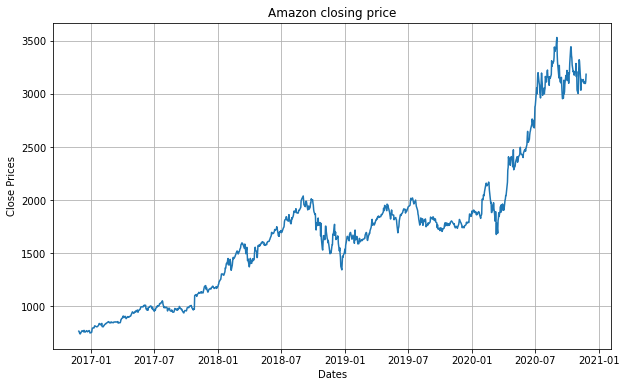

In [200]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(amz['Close'])
plt.title('Amazon closing price')
plt.show()

For the Time Series Analysis we will be using a time period of 4 years, so we'll analyze the closing price values from november 2016 to november 2020.

We can visualiza our data's behavior in the plot above, and at first sight we can see that there is a positive trend in the series.

## Check for Stationarity

The first step is to check for stationarity in our data, which means that the mean and variance values should be constant over time.

In [201]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

#Test for staionarity
def test_stationarity(timeseries):
    # Rolling mean and standard deviation test
    #Determing rolling statistics
    # we use a window of 12 to calculate at a yearly level (12 months)
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(10,6))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("\nResults of dickey fuller test")
    dft = adfuller(timeseries, autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(dft[0:4], index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in dft[4].items():
        output['Critical value (%s)'%key] =  values
    print(output)

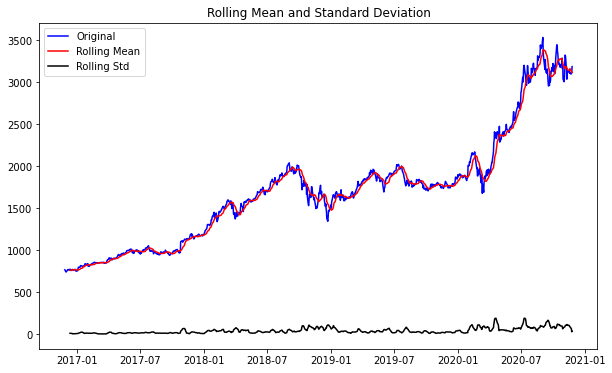


Results of dickey fuller test
Test Statistics                  0.323611
p-value                          0.978402
No. of lags used                15.000000
Number of observations used    991.000000
Critical value (1%)             -3.436966
Critical value (5%)             -2.864461
Critical value (10%)            -2.568325
dtype: float64


In [202]:
# test for stationarity in our data
test_stationarity(amz)

We plot the rolling statistics, which is a visual technique that helps us identify whether the rolling mean and std deviation remain constant and time invariant. As we can see the mean and std deviation are not constant, which means that our data is not stationary.

We also implemented the Dickey-Fuller test, which is used to reject the null hypothesis that out data is non-stationary. As we can see in the results above, the p-value is very high, of 0.978. Also, comparing the test statistics and the critical values obtained, we can say that the data is not stationary.

## Data Transformation

### Log Transformation

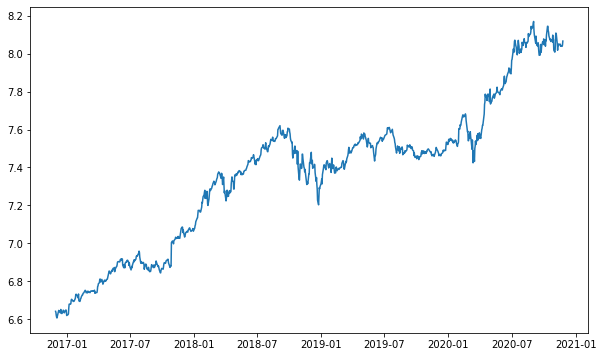

In [203]:
# taking the log of our data
# to estimate the trend
amz_log = np.log(amz)
plt.figure(figsize=(10,6))
plt.plot(amz_log)

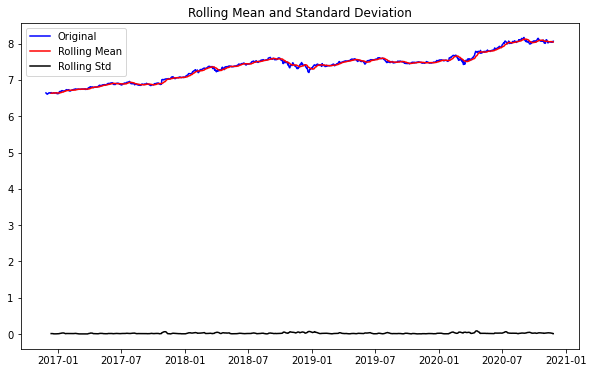


Results of dickey fuller test
Test Statistics                 -0.866115
p-value                          0.798926
No. of lags used                 9.000000
Number of observations used    997.000000
Critical value (1%)             -3.436926
Critical value (5%)             -2.864443
Critical value (10%)            -2.568316
dtype: float64


In [204]:
amz_log.dropna(inplace = True)
test_stationarity(amz_log)

#### Moving Average

No handles with labels found to put in legend.


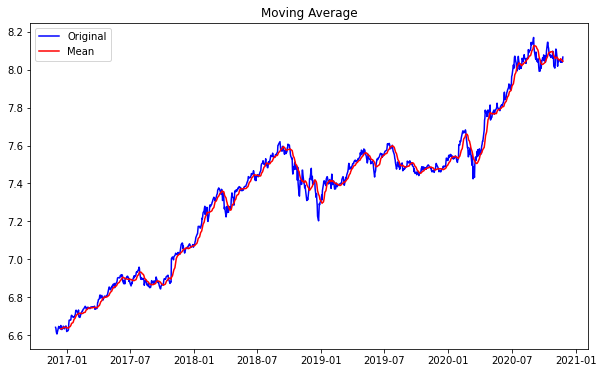

In [205]:
moving_avg = amz_log.rolling(12).mean()
std_dev = amz_log.rolling(12).std()
plt.figure(figsize=(10,6))
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(amz_log, color='blue',label='Original')
# plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Since both the log scale and the moving average have a positive trend component, we defferenciate bewteen these values to remove the trend (log - moving average).

In [206]:
log_ma_diff = amz_log - moving_avg
# log_ma_diff

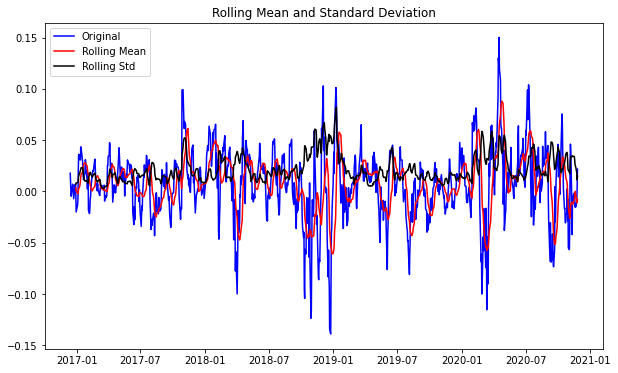


Results of dickey fuller test
Test Statistics               -7.354464e+00
p-value                        9.863322e-11
No. of lags used               1.200000e+01
Number of observations used    9.830000e+02
Critical value (1%)           -3.437020e+00
Critical value (5%)           -2.864485e+00
Critical value (10%)          -2.568338e+00
dtype: float64


In [207]:
log_ma_diff.dropna(inplace = True)
test_stationarity(log_ma_diff)

### Exponential Decay Weighted Average Transformation

We apply another transformation technique to our data.

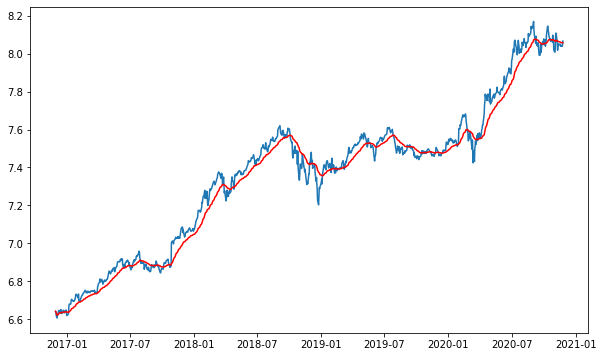

In [208]:
exp_weighted_avg = amz_log.ewm(halflife = 12).mean()
plt.figure(figsize=(10,6))
plt.plot(amz_log)
plt.plot(exp_weighted_avg, color = 'red')
plt.show()

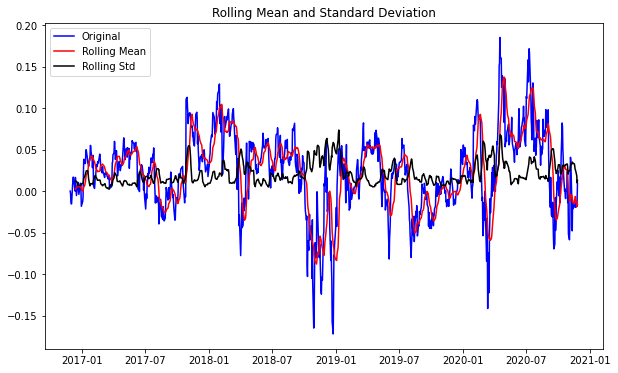


Results of dickey fuller test
Test Statistics                 -5.247001
p-value                          0.000007
No. of lags used                 9.000000
Number of observations used    997.000000
Critical value (1%)             -3.436926
Critical value (5%)             -2.864443
Critical value (10%)            -2.568316
dtype: float64


In [209]:
log_ema_diff = amz_log - exp_weighted_avg
test_stationarity(log_ema_diff)

### Diferenciation - Time Shift Transformation

In [210]:
from pmdarima.arima.utils import ndiffs

# ndiffs helps us calculate the optimal number of differenciations for our dataset
ndiffs(amz.Close, test="adf")

1

We get a value of one, which is the best number of differenciations that we should apply to our data.

In [211]:
log_diff = amz_log - amz_log.shift()
# log_diff

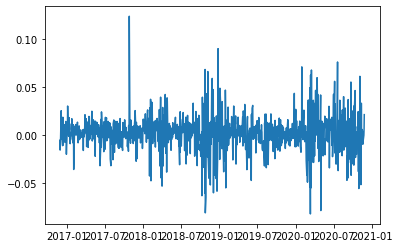

In [212]:
plt.plot(log_diff)
plt.show()

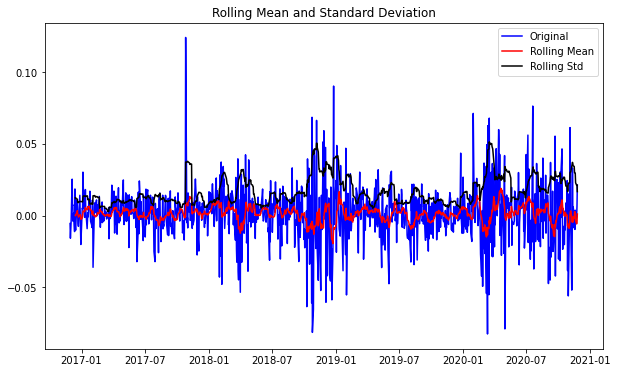


Results of dickey fuller test
Test Statistics               -1.102873e+01
p-value                        5.739593e-20
No. of lags used               8.000000e+00
Number of observations used    9.970000e+02
Critical value (1%)           -3.436926e+00
Critical value (5%)           -2.864443e+00
Critical value (10%)          -2.568316e+00
dtype: float64


In [213]:
log_diff.dropna(inplace = True)
test_stationarity(log_diff)

## Decomposition

We analyze the time series components of the amz_log.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


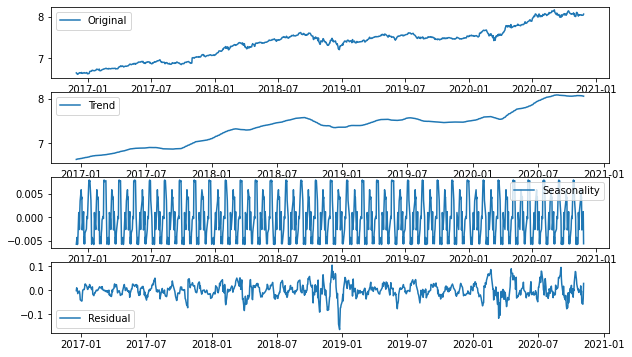

In [214]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(amz_log, freq=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,6))
plt.subplot(411)
plt.plot(amz_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

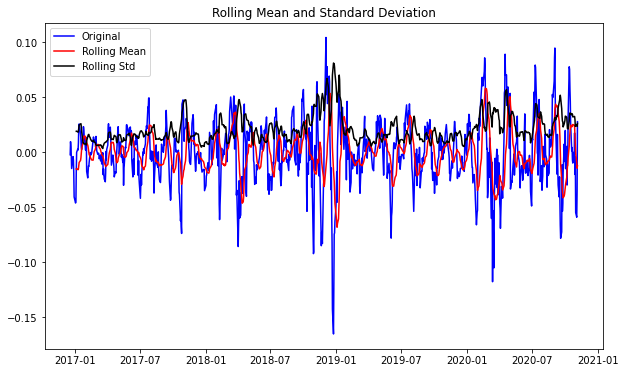


Results of dickey fuller test
Test Statistics               -9.765324e+00
p-value                        7.376126e-17
No. of lags used               2.000000e+01
Number of observations used    9.560000e+02
Critical value (1%)           -3.437209e+00
Critical value (5%)           -2.864568e+00
Critical value (10%)          -2.568382e+00
dtype: float64


In [215]:
decomposed_log = residual
decomposed_log.dropna(inplace=True)
test_stationarity(decomposed_log)

## PACF and ACF

In [216]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

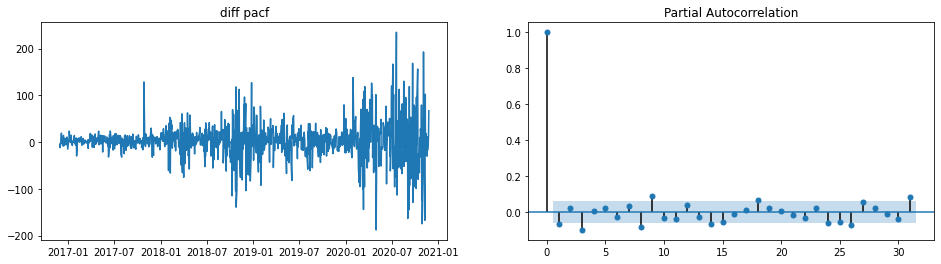

In [217]:
diff = amz.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title('diff pacf')
plot_pacf(diff, ax=ax2);

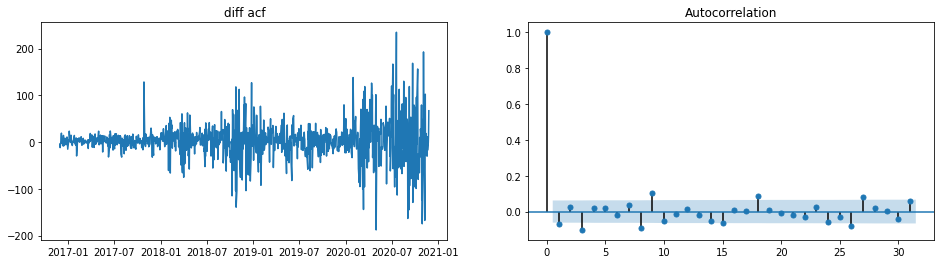

In [218]:
diff = amz.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title('diff acf')
plot_acf(diff, ax=ax2);

In [219]:
from statsmodels.tsa.stattools import acf, pacf
# Another method
lag_acf = acf(log_diff, nlags=20)
lag_pacf = pacf(log_diff, nlags=20, method='ols')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


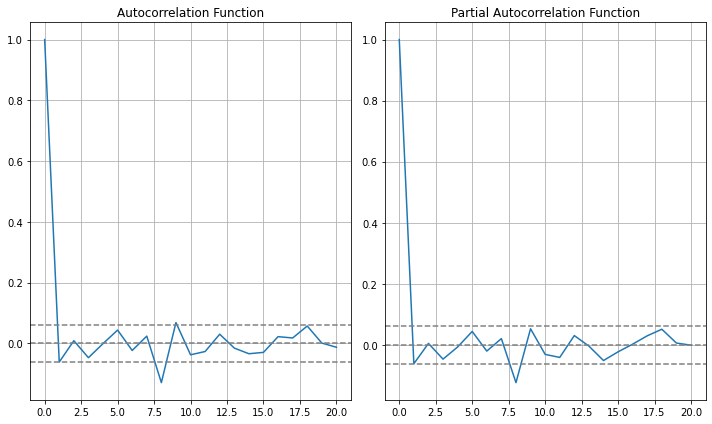

In [220]:
plt.figure(figsize=(10,6))
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray') #Add a horizontal line across the axis at y = 0.
plt.axhline(y = -1.96/np.sqrt(len(log_diff)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(log_diff)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')
plt.grid(True)

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(log_diff)), linestyle='--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(log_diff)), linestyle='--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout() #Automatically adjust subplot parameters to give specified padding.
plt.grid(True)

From the ACF graph we can see that the curve line pases the y axis on 0 when x = 1, so our q value is 1 . The same applies to the PACF graph, so our p the value would also be 1.

## Split data

In [221]:
from statsmodels.tsa.arima_model import ARIMA, ARMAResults

In [222]:
#split data into train and training set
# 90% train
# 10% test
n = int(len(amz)*0.9)
train_data, test_data = amz[0:n], amz[n:]

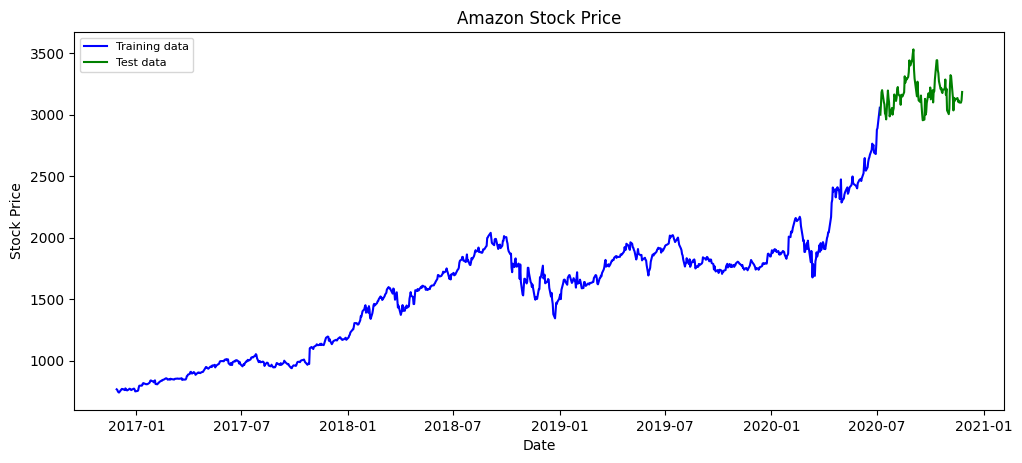

In [223]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, color = 'blue', label='Training data')
plt.plot(test_data, color = 'green',label='Test data')
plt.title('Amazon Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### ARIMA Model

In [224]:
# Build the model
model = ARIMA(train_data, order = (1,1,1))  
results_ARIMA = model.fit(disp = 0)  
print(results_ARIMA.summary())


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  905
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4415.341
Method:                       css-mle   S.D. of innovations             31.813
Date:                Fri, 27 Nov 2020   AIC                           8838.683
Time:                        10:21:58   BIC                           8857.914
Sample:                             1   HQIC                          8846.027
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.5218      1.006      2.507      0.012       0.550       4.493
ar.L1.D.Close    -0.3098      0.297     -1.043      0.297      -0.892       0.272
ma.L1.D.Close     0.2457      0.302     

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


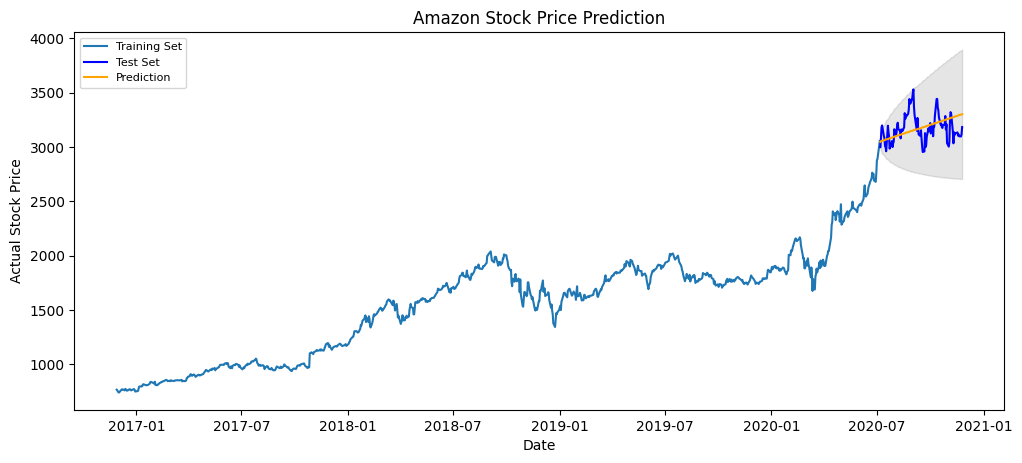

In [225]:
# Forecast and compare with the test data
fc, se, conf = results_ARIMA.forecast(len(test_data), alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Training Set')
plt.plot(test_data, color = 'blue', label='Test Set')
plt.plot(fc_series, color = 'orange',label='Prediction')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.1)
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

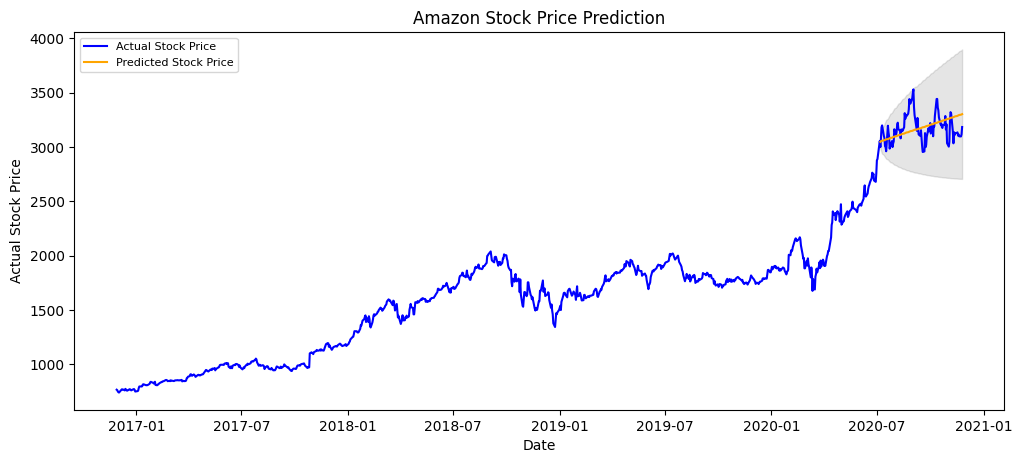

In [226]:
# Same graph as above
plt.figure(figsize=(12,5), dpi=100)
plt.plot(amz, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.1)
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

From the graph above we can see that our model is giving a good prediction of the stock values, since all of the original prices fall inside the confidence interval. However,as the prediction is linear, it cannot completely forecast the volatile nature of the stock prices.

In [227]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test_data.Close)[1]           # ACF1
    print('Results')
    print('MAPE: ', mape)
    print('MAE: ', mae)
    print('ME: ', me)
    print('MPE: ', mpe)
    print('RMSE: ', rmse)
    print('ACF1: ', acf1)
    print('Corr: ', corr)
    print('Min-Max: ', minmax)
    print('\n')

forecast_accuracy(fc, test_data.Close.values)

Results
MAPE:  0.03470488238037227
MAE:  110.92444739793113
ME:  4.0054896632221215
MPE:  0.002692631984093232
RMSE:  138.5201374126941
ACF1:  0.8426815672714498
Corr:  0.11106511521448707
Min-Max:  0.03382603833078324




/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
